In [178]:
import torch 
import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import spiral_data
nnfs.init()

In [179]:
X, y = spiral_data(samples=50, classes=3)

# convert input data into tensor
X = torch.tensor(X, dtype=torch.float32)

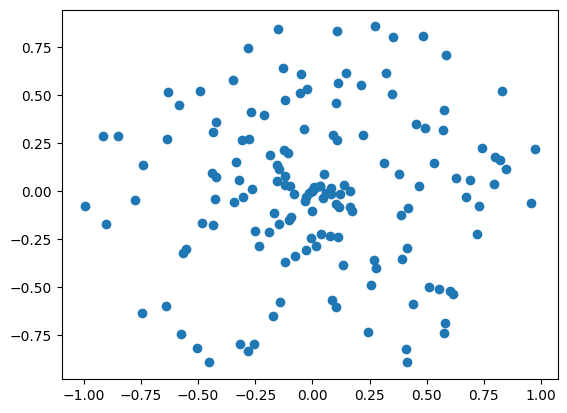

In [180]:
import matplotlib.pyplot as plt
# X, y = spiral_data( samples = 100 , classes = 1)
plt.scatter(X[:,0], X[:,1])
plt.show()

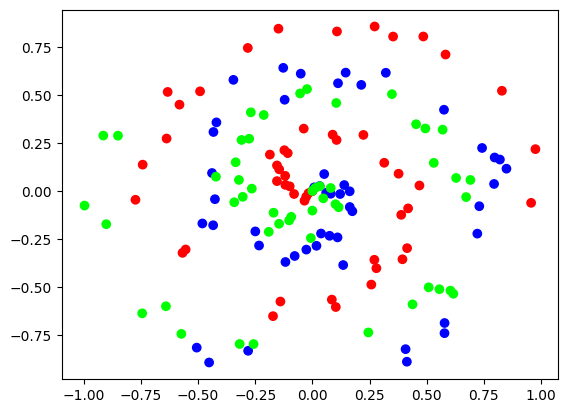

In [181]:
plt.scatter(X[:, 0 ], X[:, 1 ], c = y, cmap = 'brg' )
plt.show()

In [182]:
X.shape

torch.Size([150, 2])

In [183]:
X[:5]

tensor([[ 0.0000,  0.0000],
        [ 0.0080,  0.0188],
        [ 0.0319,  0.0255],
        [ 0.0604, -0.0099],
        [ 0.0803, -0.0146]])

In [184]:
class Linear_Layer:
    def __init__(self, n_input, n_neuron):
        self.weights =  torch.rand(n_input, n_neuron, dtype=torch.float32)
        self.bias = torch.zeros((1, n_neuron), dtype=torch.float32)
        
    def forward(self, input):
        self.output = torch.matmul(input, self.weights) + self.bias

    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = torch.dot(self.inputs.T, dvalues)
        self.dbiases = torch.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinputs = torch.dot(dvalues, self.weights.T)
    


In [185]:
# Activation function
class Activation_Relu:
    def forward(self, input):
        self.output = torch.maximum(input, torch.tensor(0.0, device=input.device))

      # Backward pass
    def backward(self, dvalues):
        # Since we need to modify the original variable,
        # let’s make a copy of values first
        self.dinputs = dvalues.copy()
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

In [186]:
# Softmax
class Activation_Softmax:
    def forward(self, input):
        exp_value = torch.exp(input - torch.max(input, dim=1, keepdim=True).values)
        probabilities = exp_value / torch.sum(exp_value, dim=1, keepdim=True)
        self.output = probabilities

In [187]:
# Common loss class
class Loss:
 # Calculates the data and regularization losses
 # given model output and ground truth values
 def calculate(self, output, y):
  # Calculate sample losses
  sample_losses = self.forward(output, y)
  # Calculate mean loss
  data_loss = torch.mean(sample_losses)
  # Return loss
  return data_loss

In [188]:
class Loss_CategoricalCrossentropy(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):
        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = torch.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = torch.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -torch.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = torch.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples

<div class="alert alert-block alert-danger">

COMBINED SOFTMAX ACTIVATION AND CATEGORICAL CROSS ENTROPY FOR LAST LAYER: FORWARD AND BACKWARD PASS</div>

In [193]:
class Activation_Softmax_Loss_CategoricalCrossentropy:
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    def forward(self, inputs, y_true):
        # softmax
        self.activation.forward(inputs)
        self.output = self.activation.output

        # loss expects: y_true as class indices OR one-hot
        return self.loss.calculate(self.output, y_true)

    def backward(self, dvalues, y_true):
        # dvalues: softmax probabilities, shape (N, C)
        samples = dvalues.shape[0]

        # if one-hot -> class indices
        if len(y_true.shape) == 2:
            y_true = torch.argmax(y_true, dim=1)   # dim not axis

        # copy tensor safely
        self.dinputs = dvalues.clone()

        # subtract 1 for correct class (vectorized)
        self.dinputs[torch.arange(samples), y_true] -= 1

        # normalize
        self.dinputs /= samples


In [195]:
# creating layers
linear1 = Linear_Layer(X.shape[1], 3)
activation1 = Activation_Relu()
linear2 = Linear_Layer(3, 3)
# activation2 = Activation_Softmax()
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

linear1.forward(X)
#print(linear1.output[:4])

activation1.forward(linear1.output)
#print(activation1.output[:4])

linear2.forward(activation1.output)
#print(linear2.output[:4])
# activation2.forward(linear2.output)
# print(activation2.output[:4])
# loss = loss_activation(linear2.output, y)